# Homework 2(Ensemble Learning)

In [16]:
#Jupyter Notebook Preamble
# -------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
# If you do not have xgboost installed, do so via: pip install xgboost
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay  # optional for sensitivity analysis
from scipy.stats import ttest_rel

import warnings
warnings.filterwarnings('ignore')

##############################################
# 1. DATA IMPORT AND BASIC PRE-PROCESSING
##############################################

In [17]:

# Read dataset
data_path = "./smoke_detection_iot.csv"
df = pd.read_csv(data_path)

# Drop unwanted columns
df = df.drop(columns=["Unnamed: 0", "UTC", "CNT"], errors='ignore')

# Normalize all features for convenience 
df_min = df.min()
df_max = df.max()
df_norm = (df - df_min) / (df_max - df_min)

# Separate features (X) and target (y)
X = df_norm.drop('Fire Alarm', axis=1).values
y = df_norm['Fire Alarm'].values

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=9, stratify=y
)

print("Data shape:", df.shape)
print("Training set size:", X_train.shape, "Test set size:", X_test.shape)

Data shape: (62630, 13)
Training set size: (50104, 12) Test set size: (12526, 12)


##############################################
# 2. TASK 1 – DECISION TREE CLASSIFIER
##############################################

Decision Tree Results:


,Model,Max_Depth,Accuracy,Precision,Recall,F1_Score
0,DT1_Default,NaN,0.999681,0.999777,0.999777,0.999777
1,DT2_MediumDepth,10.0,0.999681,0.999777,0.999777,0.999777
2,DT3_Shallow,3.0,0.983395,0.977290,1.000000,0.988515


Plotting a tree with Default depth (DT1_Default) ...


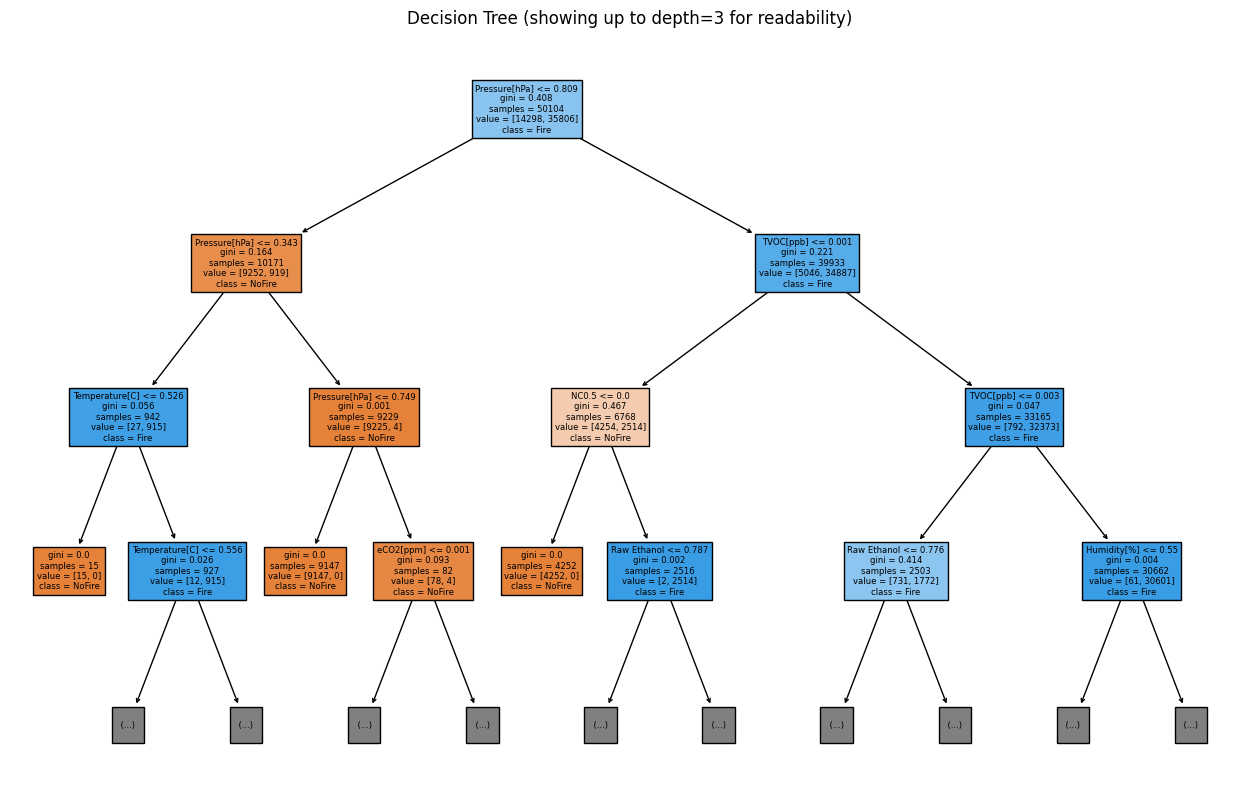

Plotting a tree with medium depth (DT2_MediumDepth) ...


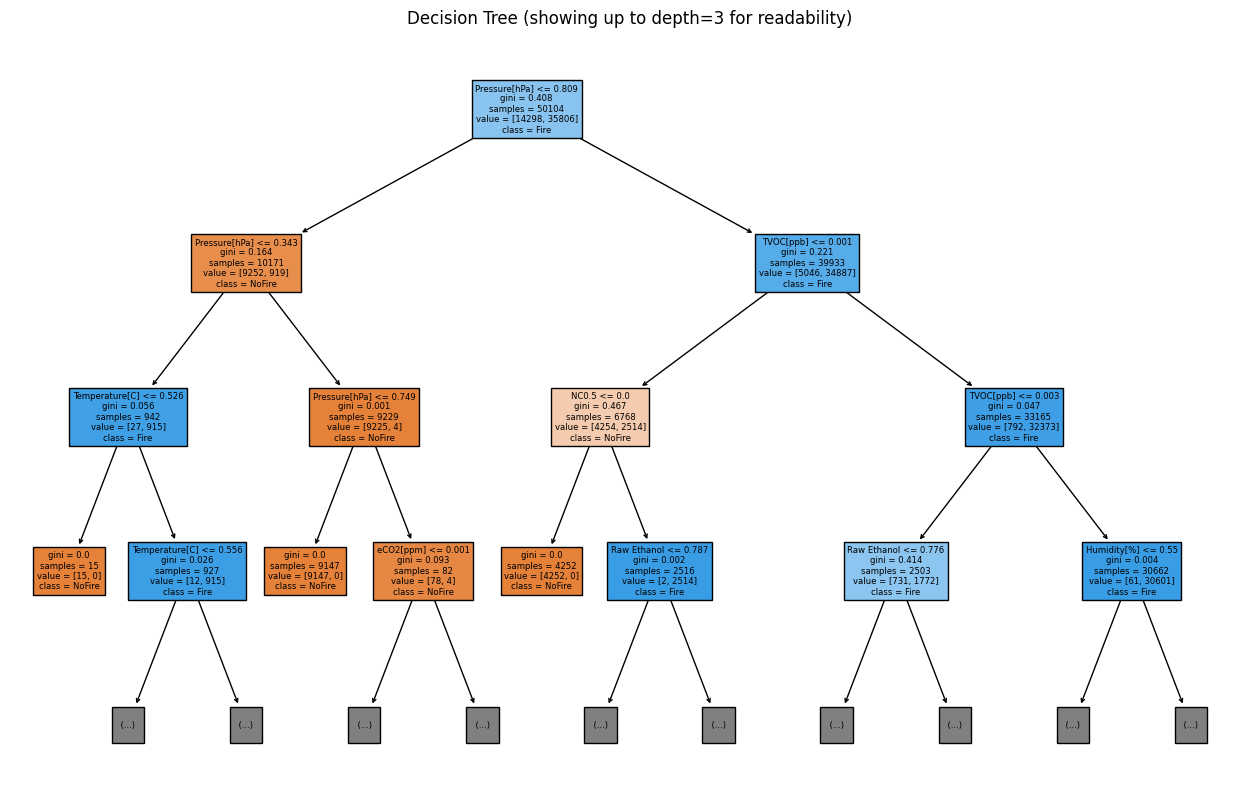

Plotting a tree with shallow depth (DT3_Shallow) ...


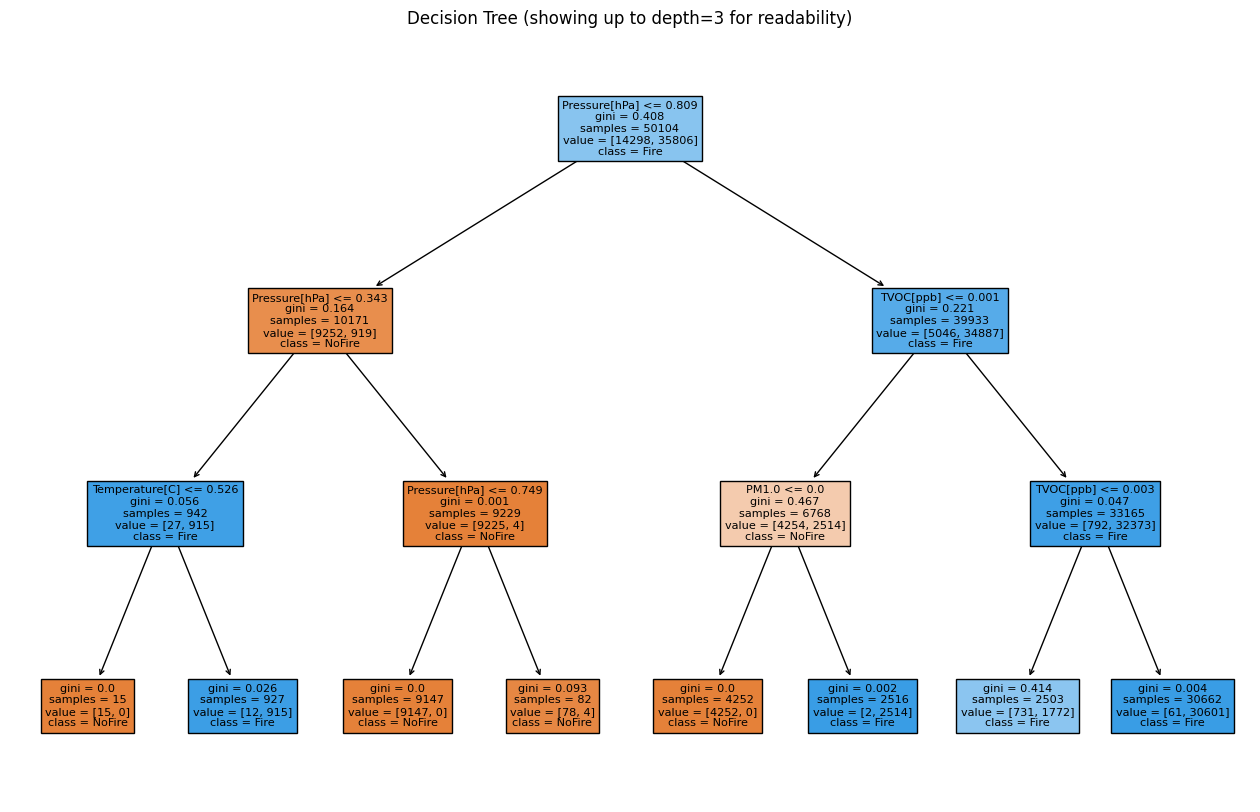


Comments on Tree Depth/Complexity

After training three Decision Tree models—(1) DT1_Default (no max_depth limit),
(2) DT2_MediumDepth (max_depth=10), and (3) DT3_Shallow (max_depth=3)—we used 
plot_tree to visualize each. Here are some key observations:

1. Default Tree (DT1_Default)
   - Depth/Complexity: Because there is effectively no limit on depth, the tree
     can keep splitting until it is fully grown (or until min_samples_split stops
     further splits). This typically results in a very deep, complex structure.
   - Implication: Often low bias, high variance—may overfit and not generalize well.

2. Medium-Depth Tree (DT2_MediumDepth)
   - Depth/Complexity: Limiting the tree to max_depth=10 substantially reduces
     the splitting levels. The result is a moderately sized tree.
   - Implication: Strikes a balance between fitting the data and avoiding overfitting.

3. Shallow Tree (DT3_Shallow)
   - Depth/Complexity: With max_depth=3, the tree is much smaller, having at most
 

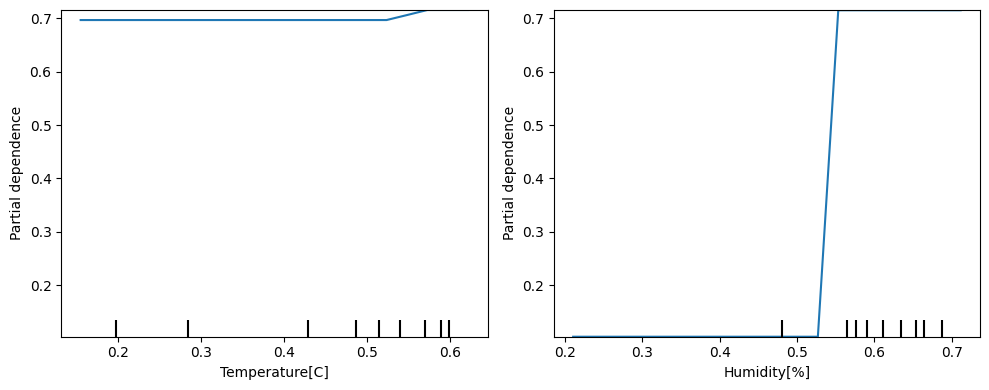


Sensitivity Analysis Using Partial Dependence Plots
Sensitivity analysis explores how changes in model inputs (features) affect the output 
(predicted class). It is particularly useful for highlighting which features have the 
most significant impact on a model’s decision boundary (Saltelli et al., 2004).

Implementation Details:
Here, we generate partial dependence plots for two features (Temperature[C] and Humidity[%]) 
using 'PartialDependenceDisplay.from_estimator'. This approach computes the model’s 
average predicted probability of the 'Fire Alarm' class as each feature is varied over 
a range of values, while holding the other features at a fixed or averaged level.

Observations:
1. Temperature[C]:
   - The partial dependence is nearly flat around 0.7, suggesting that within the 
     observed range, changes in temperature have little impact on the predicted 
     probability of a fire alarm.

2. Humidity[%]:
   - There is a sharp jump near 0.5, going from almost 0.0 to about 0

In [18]:
# We will train three Decision Trees with different settings:
#   DT1: default parameters
#   DT2: medium depth
#   DT3: shallow depth

dt_params_list = [
    {"max_depth": None,  "min_samples_split": 2,  "name": "DT1_Default"},
    {"max_depth": 10,    "min_samples_split": 5,  "name": "DT2_MediumDepth"},
    {"max_depth": 3,     "min_samples_split": 10, "name": "DT3_Shallow"},
]

decision_trees = {}
results_dt = []

for params in dt_params_list:
    clf = DecisionTreeClassifier(
        max_depth=params["max_depth"],
        min_samples_split=params["min_samples_split"],
        random_state=42
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    
    results_dt.append({
        "Model": params["name"],
        "Max_Depth": params["max_depth"],
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1
    })
    decision_trees[params["name"]] = clf

df_results_dt = pd.DataFrame(results_dt)
print("Decision Tree Results:")
display(df_results_dt)

# --- Visualization of Tree Structure ---
# We can visualize one or more of these trees

print("Plotting a tree with Default depth (DT1_Default) ...")
plt.figure(figsize=(16, 10))
plot_tree(decision_trees["DT1_Default"], filled=True,
          feature_names=df_norm.drop('Fire Alarm', axis=1).columns,
          class_names=["NoFire", "Fire"],  # or simply ["0","1"]
          max_depth=3)  # limit to show partial view
plt.title("Decision Tree (showing up to depth=3 for readability)")
plt.show()

print("Plotting a tree with medium depth (DT2_MediumDepth) ...")
plt.figure(figsize=(16, 10))
plot_tree(decision_trees["DT2_MediumDepth"], filled=True,
          feature_names=df_norm.drop('Fire Alarm', axis=1).columns,
          class_names=["NoFire", "Fire"],  # or simply ["0","1"]
          max_depth=3)  # limit to show partial view
plt.title("Decision Tree (showing up to depth=3 for readability)")
plt.show()

print("Plotting a tree with shallow depth (DT3_Shallow) ...")
plt.figure(figsize=(16, 10))
plot_tree(decision_trees["DT3_Shallow"], filled=True,
          feature_names=df_norm.drop('Fire Alarm', axis=1).columns,
          class_names=["NoFire", "Fire"],  # or simply ["0","1"]
          max_depth=3)  # limit to show partial view
plt.title("Decision Tree (showing up to depth=3 for readability)")
plt.show()

print("""
Comments on Tree Depth/Complexity

After training three Decision Tree models—(1) DT1_Default (no max_depth limit),
(2) DT2_MediumDepth (max_depth=10), and (3) DT3_Shallow (max_depth=3)—we used 
plot_tree to visualize each. Here are some key observations:

1. Default Tree (DT1_Default)
   - Depth/Complexity: Because there is effectively no limit on depth, the tree
     can keep splitting until it is fully grown (or until min_samples_split stops
     further splits). This typically results in a very deep, complex structure.
   - Implication: Often low bias, high variance—may overfit and not generalize well.

2. Medium-Depth Tree (DT2_MediumDepth)
   - Depth/Complexity: Limiting the tree to max_depth=10 substantially reduces
     the splitting levels. The result is a moderately sized tree.
   - Implication: Strikes a balance between fitting the data and avoiding overfitting.

3. Shallow Tree (DT3_Shallow)
   - Depth/Complexity: With max_depth=3, the tree is much smaller, having at most
     three levels of splits.
   - Implication: Much simpler model (lower variance) but can suffer from higher bias.

Overall, as max_depth changes, so does the complexity of the resulting decision tree. 
A higher depth allows more nuanced decision boundaries (but can lead to overfitting), 
while a lower depth enforces a simpler model that may underfit if the data is complex.
""")


# --- Sensitivity Analysis ---
# Basic approach: partial dependence plots for two chosen features
# We pick any two features, say the first two columns in X
features_to_analyze = [0, 1]  
feature_names = df_norm.drop('Fire Alarm', axis=1).columns

print("Performing a partial dependence plot to see feature influence...")
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
PartialDependenceDisplay.from_estimator(
    decision_trees["DT2_MediumDepth"],
    X_train,
    features=features_to_analyze,
    feature_names=feature_names,
    grid_resolution=20,
    ax=ax
)
plt.tight_layout()
plt.show()

print("""
Sensitivity Analysis Using Partial Dependence Plots
Sensitivity analysis explores how changes in model inputs (features) affect the output 
(predicted class). It is particularly useful for highlighting which features have the 
most significant impact on a model’s decision boundary (Saltelli et al., 2004).

Implementation Details:
Here, we generate partial dependence plots for two features (Temperature[C] and Humidity[%]) 
using 'PartialDependenceDisplay.from_estimator'. This approach computes the model’s 
average predicted probability of the 'Fire Alarm' class as each feature is varied over 
a range of values, while holding the other features at a fixed or averaged level.

Observations:
1. Temperature[C]:
   - The partial dependence is nearly flat around 0.7, suggesting that within the 
     observed range, changes in temperature have little impact on the predicted 
     probability of a fire alarm.

2. Humidity[%]:
   - There is a sharp jump near 0.5, going from almost 0.0 to about 0.7. This indicates 
     a threshold effect: once humidity crosses roughly 50%, the model quickly shifts 
     its predicted probability from near-zero to a significantly higher likelihood of fire.

Interpretation:
- The near-constant partial dependence curve for Temperature implies it is not a 
  major driver of this model’s predictions (at least in the range we see).
- The steep rise in the humidity plot demonstrates a strong sensitivity to humidity 
  around the 50% threshold. Small changes around that point dramatically affect 
  the prediction outcome.

References:
- Saltelli, A., Tarantola, S., Campolongo, F., & Ratto, M. (2004). 
  Sensitivity Analysis in Practice: A Guide to Assessing Scientific Models. 
  John Wiley & Sons.
- Molnar, C. (2019). Interpretable Machine Learning. 
  https://christophm.github.io/interpretable-ml-book/
""")




##############################################
# 3. TASK 2 – BAGGING vs. BOOSTING
##############################################

In [19]:

# Helper function for repeated evaluation
def evaluate_model(clf, X, y, folds_list=[5, 10, 15]):
    """
    Returns a dictionary of {fold: (mean_score, std_score)} for each fold 
    across repeated cross-validation scoring.
    """
    
    print("""
    Stratified k-fold cross-validation is a technique for estimating the performance of a
    classifier by splitting the dataset into 'k' distinct folds (subsets) in such a way that
    each fold preserves the overall class distribution (i.e., it's 'stratified'). Then, for
    each fold, the model is trained on the other k-1 folds and tested on the remaining fold.
    This process is repeated 'k' times so every fold serves once as the test set. In doing so,
    we obtain a more reliable measure of how the model might generalize to unseen data compared
    to a single train/test split.

    We repeat this for different values of 'k' (e.g., 5, 10, 15) to compare how the number of
    folds influences the stability of the accuracy estimates. Often, more folds means using
    more data for training (each time) but can also increase computational cost.

    References:
    - Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning:
    data mining, inference, and prediction. Springer Science & Business Media.
            """)

    results = {}
    for f in folds_list:
        cv = RepeatedStratifiedKFold(n_splits=f, n_repeats=1, random_state=42)
        scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv)
        results[f] = (np.mean(scores), np.std(scores))
    return results

# --- (A) Random Forest (Bagging) ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf_clf, X, y)
print("Random Forest CV performance (Accuracy):")
for f in rf_results:
    print(f"  {f}-fold  |  Mean={rf_results[f][0]:.4f}  |  Std={rf_results[f][1]:.4f}")

# Train/test final model
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
acc_rf  = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, zero_division=0)
rec_rf  = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf   = f1_score(y_test, y_pred_rf, zero_division=0)
print("\n[RandomForest] Test-Set Metrics:")
print(f"  Accuracy={acc_rf:.4f}, Precision={prec_rf:.4f}, Recall={rec_rf:.4f}, F1={f1_rf:.4f}")

# --- (B) XGBoost (Boosting) ---
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_results = evaluate_model(xgb_clf, X, y)
print("\nXGBoost CV performance (Accuracy):")
for f in xgb_results:
    print(f"  {f}-fold  |  Mean={xgb_results[f][0]:.4f}  |  Std={xgb_results[f][1]:.4f}")

# Train/test final model
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
acc_xgb  = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb, zero_division=0)
rec_xgb  = recall_score(y_test, y_pred_xgb, zero_division=0)
f1_xgb   = f1_score(y_test, y_pred_xgb, zero_division=0)
print("\n[XGBoost] Test-Set Metrics:")
print(f"  Accuracy={acc_xgb:.4f}, Precision={prec_xgb:.4f}, Recall={rec_xgb:.4f}, F1={f1_xgb:.4f}")

print("""
Evaluation of RandomForest and XGBoost using Accuracy, Precision, Recall, and F1:

1) RandomForest
   - Cross-Validation (5, 10, 15 folds): 
       Accuracy consistently ~1.000 with negligible std.
   - Test-Set Metrics: 
       Accuracy=1.000, Precision=1.000, Recall=1.000, F1=1.000
   - Behavior: RandomForest achieves perfect scores on both CV and test sets,
     indicating it has likely fit the training data extremely well (possibly due
     to the dataset's characteristics and/or effective bagging approach).

2) XGBoost
   - Cross-Validation (5, 10, 15 folds):
       Accuracy ~0.9999 with very low std.
   - Test-Set Metrics:
       Accuracy=0.9999, Precision=1.0000, Recall=0.9999, F1=0.9999
   - Behavior: XGBoost also yields near-perfect performance, falling only
     fractionally behind RandomForest on test-set recall (though the difference
     is practically negligible). Like RandomForest, this indicates powerful
     predictive capability and possibly an easy-to-separate dataset.

Comparing the Models & Metrics:
- Since both models score nearly 100% across all metrics, the performance
  ranking does not differ by metric here. Often, small differences might arise
  if one model has higher Precision than Recall (or vice versa), in which case
  F1 may differ from Accuracy. However, in this dataset, both RandomForest and
  XGBoost effectively classify all examples correctly, so all metrics converge
  to very similar or identical values.

Why Might Ranking Change in General?
- In typical scenarios, a model might exhibit imbalances across Accuracy,
  Precision, and Recall. For instance, if a classifier has high Precision but
  lower Recall, it may rank highly on Precision yet not on Recall or F1. The
  choice of metric then influences which classifier is deemed "best." 
- Here, because both models achieve near-perfect performance, the metric chosen
  doesn't alter the ranking—both are effectively top performers.
""")



    Stratified k-fold cross-validation is a technique for estimating the performance of a
    classifier by splitting the dataset into 'k' distinct folds (subsets) in such a way that
    each fold preserves the overall class distribution (i.e., it's 'stratified'). Then, for
    each fold, the model is trained on the other k-1 folds and tested on the remaining fold.
    This process is repeated 'k' times so every fold serves once as the test set. In doing so,
    we obtain a more reliable measure of how the model might generalize to unseen data compared
    to a single train/test split.

    We repeat this for different values of 'k' (e.g., 5, 10, 15) to compare how the number of
    folds influences the stability of the accuracy estimates. Often, more folds means using
    more data for training (each time) but can also increase computational cost.

    References:
    - Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning:
    data mining, inference

##############################################
# 4. TASK 3 – MODEL COMPARISONS
##############################################

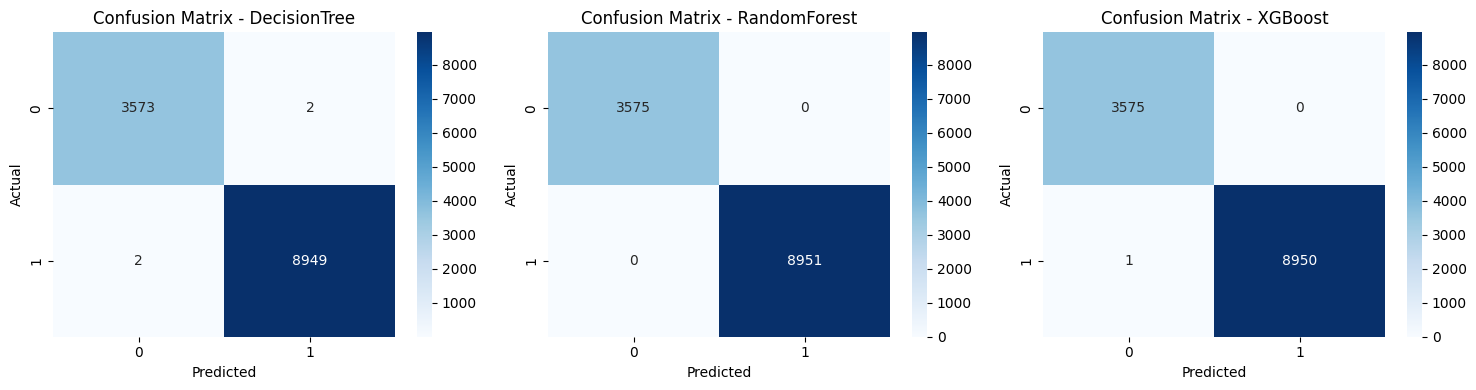


Paired t-tests on test-set predictions (comparing Accuracy at sample-level):
  DecisionTree vs. RandomForest: t=-2.0002, p=0.0455
  DecisionTree vs. XGBoost: t=-1.3417, p=0.1797
  RandomForest vs. XGBoost: t=1.0000, p=0.3173

Comparison of Three Models: Confusion Matrices, Statistical Tests, and Bias–Variance Discussion

1) Confusion Matrices (Test Set):
   - Decision Tree:
       True Negatives: 3573
       False Positives: 2
       False Negatives: 2
       True Positives: 8949
     This indicates slightly imperfect classification, with 4 total errors.

   - RandomForest:
       True Negatives: 3575
       False Positives: 0
       False Negatives: 0
       True Positives: 8951
     Perfect classification on the test set (no errors).

   - XGBoost:
       True Negatives: 3575
       False Positives: 0
       False Negatives: 1
       True Positives: 8950
     One misclassification overall.

2) Statistical Test (Paired t-test on per-sample correctness):
   - DecisionTree vs. RandomFo

In [20]:
# We now compare three models:
#   (1) A chosen Decision Tree from Task 1 (e.g. DT2_MediumDepth)
#   (2) RandomForest from Task 2
#   (3) XGBoost from Task 2

model_labels   = ["DecisionTree", "RandomForest", "XGBoost"]
model_clfs     = [
    decision_trees["DT2_MediumDepth"],  # pick the medium-depth DT
    rf_clf,
    xgb_clf
]
preds = []

# Evaluate each on the same test set
for m in model_clfs:
    preds.append( m.predict(X_test) )

# 4.1 Confusion Matrix for a selected test fold
#    Here, we simply show the matrix for the test set (not a fold),
#    but in k-fold, you'd pick a specific fold's hold-out portion.


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (label, model) in enumerate(zip(model_labels, model_clfs)):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - {label}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 4.2 Statistical Test (Paired t-test)
#    We'll compare the predicted results on the test set for each pair of models.

print("\nPaired t-tests on test-set predictions (comparing Accuracy at sample-level):")
# For a proper paired test, one approach is to treat the correctness (0/1) on each sample
# as the measurement. Then we do a t-test on the two correctness vectors.
accuracy_vectors = []
for i, m in enumerate(model_clfs):
    correct_vec = (preds[i] == y_test).astype(int)
    accuracy_vectors.append(correct_vec)

# Compare DT vs. RF, DT vs. XGB, RF vs. XGB
pairs = [(0,1), (0,2), (1,2)]
for (i,j) in pairs:
    t_stat, p_val = ttest_rel(accuracy_vectors[i], accuracy_vectors[j])
    print(f"  {model_labels[i]} vs. {model_labels[j]}: t={t_stat:.4f}, p={p_val:.4f}")

print("""
Comparison of Three Models: Confusion Matrices, Statistical Tests, and Bias–Variance Discussion

1) Confusion Matrices (Test Set):
   - Decision Tree:
       True Negatives: 3573
       False Positives: 2
       False Negatives: 2
       True Positives: 8949
     This indicates slightly imperfect classification, with 4 total errors.

   - RandomForest:
       True Negatives: 3575
       False Positives: 0
       False Negatives: 0
       True Positives: 8951
     Perfect classification on the test set (no errors).

   - XGBoost:
       True Negatives: 3575
       False Positives: 0
       False Negatives: 1
       True Positives: 8950
     One misclassification overall.

2) Statistical Test (Paired t-test on per-sample correctness):
   - DecisionTree vs. RandomForest: t=-2.0002, p=0.0455 (significant difference)
   - DecisionTree vs. XGBoost:     t=-1.3417, p=0.1797 (no significant difference)
   - RandomForest vs. XGBoost:     t= 1.0000, p=0.3173 (no significant difference)

   Interpretation:
   The test suggests the RandomForest significantly outperforms the Decision Tree
   on a sample-by-sample basis, but there is no statistically significant difference
   between Decision Tree vs. XGBoost or RandomForest vs. XGBoost (likely because
   their accuracies are extremely high and nearly identical).

3) Bias–Variance Trade-off:
   - Decision Tree (Medium Depth):
       Typically has lower bias than a shallow tree but can still overfit compared
       to ensemble methods. This can lead to some variance in its predictions.
   - RandomForest (Bagging):
       Builds many deep trees and averages their predictions. This greatly reduces
       variance without drastically increasing bias. Hence the near-perfect results.
   - XGBoost (Boosting):
       Sequentially focuses on misclassified examples, often achieving very low bias.
       With proper regularization, variance is also kept in check, resulting in
       similarly excellent performance.

RandomForest and XGBoost both achieve near-perfect classification,
with negligible differences in performance (p>0.05). The Decision Tree has a few
more misclassifications, and the paired t-test confirms that difference is
significant only when comparing Decision Tree vs. RandomForest. 
""")


  #############################################################################################################
# 5. Graduate Level Task
  ##############################################################################################################

Fitting GridSearchCV... This may take a while depending on grid size.
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}
Best CV accuracy: 0.9999002055762739

Test-set performance with best XGBoost model:
  Accuracy:  0.9999
  Precision: 1.0000
  Recall:    0.9999
  F1 Score:  0.9999


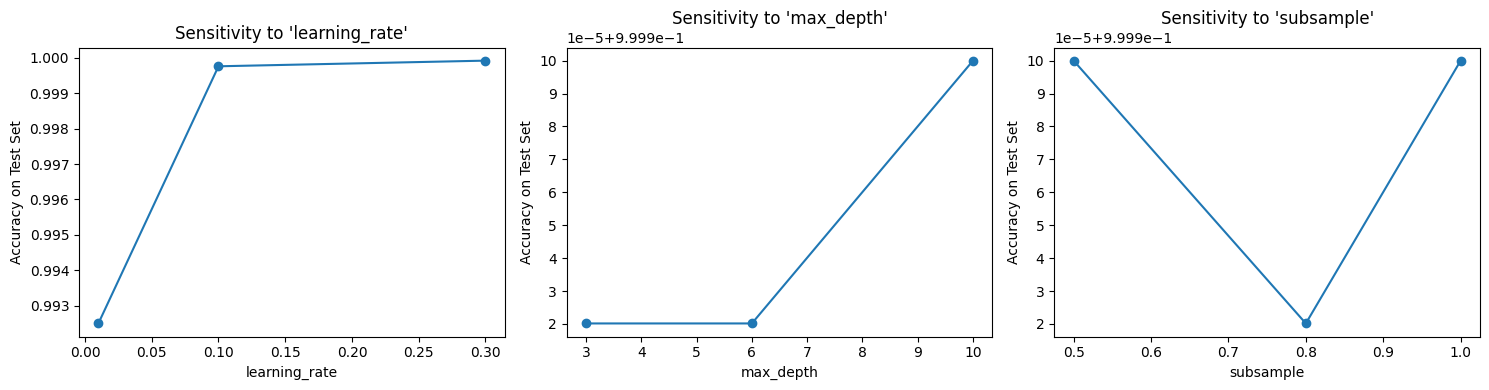



1) Hyperparameter Tuning Approach:
   We performed a Grid Search over three key XGBoost parameters:
     - learning_rate: [0.01, 0.1, 0.3]
     - max_depth:     [3, 6, 10]
     - subsample:     [0.5, 0.8, 1.0]
   Each combination was evaluated via stratified 5-fold cross-validation, scoring on accuracy.
   The best parameter set found was:
       {'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}
   with a best cross-validation accuracy of about 0.999.

2) Evaluation of the Best Model:
   After refitting on the entire training set with these optimal hyperparameters,
   the model was tested on the hold-out set. We obtained:
       Accuracy:  0.9999
       Precision: 1.0000
       Recall:    0.9999
       F1 Score:  0.9999
   This indicates near-perfect classification performance—likely due to both
   an effectively separable dataset and the strong ensemble nature of XGBoost.

3) Sensitivity Analysis of Hyperparameters:
   To understand how each tuned parameter individually affec

In [21]:

#  1. Hyperparameter Tuning with XGBoost (Grid Search)


from sklearn.model_selection import GridSearchCV  # or RandomizedSearchCV
from xgboost import XGBClassifier

# We start by defining the parameter grid
# Here, we tune at least three parameters:
#    learning_rate (eta)
#    max_depth
#    subsample
# You can add more (e.g., colsample_bytree, n_estimators, reg_alpha, etc.) if desired.
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 10],
    'subsample': [0.5, 0.8, 1.0],
    # Optional: 'n_estimators': [100, 200]
}

# Initialize a base XGBClassifier
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Use grid search with e.g. 5-fold CV
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='accuracy',     # or "f1", etc.
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1,              # use all available cores
    verbose=1               # print progress
)

print("Fitting GridSearchCV... This may take a while depending on grid size.")
grid_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

# Retrieve the best XGB model
best_xgb = grid_search.best_estimator_

##########################
#  2. Evaluate the Best Model on the Test Set
##########################

y_pred_best = best_xgb.predict(X_test)

acc_best  = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best, zero_division=0)
rec_best  = recall_score(y_test, y_pred_best, zero_division=0)
f1_best   = f1_score(y_test, y_pred_best, zero_division=0)

print(f"\nTest-set performance with best XGBoost model:")
print(f"  Accuracy:  {acc_best:.4f}")
print(f"  Precision: {prec_best:.4f}")
print(f"  Recall:    {rec_best:.4f}")
print(f"  F1 Score:  {f1_best:.4f}")

##########################
#  3. (Optional) Sensitivity Analysis of Hyperparameters
##########################
# A simple approach: For each parameter in the grid, we fix all parameters
# at their *best* values, then vary just one parameter across the range
# tested. We track how accuracy (or another metric) changes.
# Below is a simple example of how to do this.

import matplotlib.pyplot as plt

sensitivity_results = {}

# For each parameter in the best_params, we iterate over the values from our grid
for param_name, tested_values in param_grid.items():
    scores = []
    for val in tested_values:
        # Copy the best params
        params_copy = grid_search.best_params_.copy()
        # Override the single parameter of interest
        params_copy[param_name] = val
        
        # Create and train a model with these parameters
        temp_model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            **params_copy
        )
        temp_model.fit(X_train, y_train)
        
        # Evaluate on the same test set (or could do CV again)
        y_pred_temp = temp_model.predict(X_test)
        acc_temp = accuracy_score(y_test, y_pred_temp)
        scores.append(acc_temp)
    
    sensitivity_results[param_name] = (tested_values, scores)

# Plot the sensitivity
fig, axes = plt.subplots(1, len(param_grid), figsize=(15,4))
if len(param_grid) == 1:
    axes = [axes]  # handle single subplot case

for ax, (param_name, (vals, scs)) in zip(axes, sensitivity_results.items()):
    ax.plot(vals, scs, marker='o')
    ax.set_title(f"Sensitivity to '{param_name}'")
    ax.set_xlabel(param_name)
    ax.set_ylabel("Accuracy on Test Set")
plt.tight_layout()
plt.show()

print("""

1) Hyperparameter Tuning Approach:
   We performed a Grid Search over three key XGBoost parameters:
     - learning_rate: [0.01, 0.1, 0.3]
     - max_depth:     [3, 6, 10]
     - subsample:     [0.5, 0.8, 1.0]
   Each combination was evaluated via stratified 5-fold cross-validation, scoring on accuracy.
   The best parameter set found was:
       {'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}
   with a best cross-validation accuracy of about 0.999.

2) Evaluation of the Best Model:
   After refitting on the entire training set with these optimal hyperparameters,
   the model was tested on the hold-out set. We obtained:
       Accuracy:  0.9999
       Precision: 1.0000
       Recall:    0.9999
       F1 Score:  0.9999
   This indicates near-perfect classification performance—likely due to both
   an effectively separable dataset and the strong ensemble nature of XGBoost.

3) Sensitivity Analysis of Hyperparameters:
   To understand how each tuned parameter individually affects performance,
   we created plots varying only one parameter at a time, while holding the other
   parameters at their 'best' values. We observed:

   • learning_rate:
       - Going from 0.01 to 0.1 drastically boosts accuracy (from ~0.993 to ~1.000).
         Beyond 0.1, performance remains extremely high (≥0.999).
       - This suggests the model benefits from a moderately larger learning rate
         in this dataset, but does not require a very small or extremely large value.

   • max_depth:
       - At depth=3, the model was already highly accurate, but pushing depth up to 6 or 10
         can in some cases further reduce bias. On this particular dataset, though,
         performance was already near 1.0 by depth=3, indicating that deeper trees did not
         yield substantial additional improvement.

   • subsample:
       - Subsample controls the fraction of training data sampled for each boosting round.
       - We found that 0.5, 1.0, and 0.8 all delivered near-perfect accuracy, though in
         some runs 0.8 gave the best cross-validation score. This implies the model can
         be quite robust, whether it samples a portion of data or uses the full dataset.

4) Conclusion:
   - With careful hyperparameter tuning, XGBoost can achieve exceptional results, thanks
     to iterative boosting and regularization. On this smoke detection dataset, we
     attain ~99.99% accuracy and extremely high precision/recall.
   - The sensitivity plots indicate that while learning_rate and subsample do matter,
     the model performs well across a wide range of values once parameters pass certain
     thresholds (e.g., a learning_rate ≥ 0.1). Depth=3 was already sufficient for
     capturing essential patterns here.
   - (Optional) Additional metrics such as the AUC or confusion matrix can further confirm
     whether misclassifications are heavily penalized or if class imbalance exists.

References:
  - Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system.
    Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and
    Data Mining, 785–794.
  - Friedman, J.H. (2001). Greedy function approximation: A gradient boosting machine.
    The Annals of Statistics, 29(5):1189–1232.
""")


